# Quantization

Before starting this stage, adjust and run the following snippet to reset the HNSW config parameters to their default values (since the quantization will interact with the HNSW config parameters and it will affect the speed and the search accuracy):

```python
client.update_collection(
     collection_name=COLLECTION_NAME,
     hnsw_config=models.HnswConfigDiff(
        m=16,
        ef_construct=100,
     )
)

while True:
    collection_info = client.get_collection(collection_name=COLLECTION_NAME)
    if collection_info.status == models.CollectionStatus.GREEN:
        break
```


## Theory

Quantization is a way to reduce the precision of high-dimensional vectors to make the database more efficient in terms of storage and inference speed. It involves converting floating-point numbers to lower-precision types and trying to compress the vectors without loosing too much accuracy.

Qdrant supports 3 types of quantization out of the box (meaning that you don't have to preprocess the embeddings separately, and can quantize them inside of Qdrant itself, and also store the quantized vectors alongside the original ones without much configuration). Here are their brief descriptions:

- **Scalar quantization** reduces the precision of vector elements to a set of predefined values. It's also known as uniform quantization and it maps floating-point numbers to integers like 8-bit. This type is perhaps the most universal one in terms of retaining high accuracy, but it only can speed up the search up to 2 times and reduce the storage by a factor of 4.

- **Product quantization** divides a high-dimensional vector into multiple sub-vectors and quantizes each sub-vector independently. This is the most compressing type out of 3, but it might drop the accuracy significantly. You can read more on the inner working of product quantization in the Faiss book at Pinecone.

- **Binary quantization** is a type of quantization where each vector component is represented by just 1 bit, either 0 or 1. This is more extreme than other forms of quantization, which might use 4 or 8 bits. Reducing each number to a single bit drastically reduces storage needs and speeds up the queries, but also induces a significant loss in accuracy because so much information is lost. Binary quantization does not work universally well with any embedding model (although it does seem to work with the text-embedding-ada-002, which we are using, and Cohere embeddings), so binary quantization should be applied carefully and mostly to the tested models that can retain accuracy.


## Objectives

In this stage, you will also modify the k-NN vs ANN accuracy and speed function from the previous stages. Here, we ask you to update the collection with a quantization config and scalar quantization. Here is the code you can use:


In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import time
from typing import List, Dict

# Import functions from the qdrant_evaluation package
from qdrant_evaluation import (
    get_client,
    load_test_dataset,
    evaluate_ann,
    results_to_dataframe,
    update_collection_config,
    evaluate_collection_with_config,
    evaluate_with_quantization
)
from qdrant_client import QdrantClient, models

# Define constants
QDRANT_HOST = "localhost"
QDRANT_PORT = 6333
COLLECTION_NAME = 'arxiv_papers'
k = 10

# Initialize Qdrant client
client = get_client(host=QDRANT_HOST, port=QDRANT_PORT)


In [2]:
# Reset HNSW config parameters to their default values
client.update_collection(
     collection_name=COLLECTION_NAME,
     hnsw_config=models.HnswConfigDiff(
        m=16,
        ef_construct=100,
     )
)

while True:
    collection_info = client.get_collection(collection_name=COLLECTION_NAME)
    if collection_info.status == models.CollectionStatus.GREEN:
        break
    time.sleep(10)
    print("Waiting for collection to be ready...")

print("Collection is ready with default HNSW parameters")


Collection is ready with default HNSW parameters


In [3]:
# Update collection with scalar quantization
client.update_collection(
    collection_name=COLLECTION_NAME,
    optimizer_config=models.OptimizersConfigDiff(),
    quantization_config=models.ScalarQuantization(
        scalar=models.ScalarQuantizationConfig(
            type=models.ScalarType.INT8,
            quantile=0.99,
            always_ram=False,
        ),
    ),
)

while True:
    collection_info = client.get_collection(collection_name=COLLECTION_NAME)
    if collection_info.status == models.CollectionStatus.GREEN:
        break
    time.sleep(10)
    print("Waiting for collection to be ready after quantization...")

print("Collection is ready with scalar quantization applied")


Collection is ready with scalar quantization applied


Once you quantize the embeddings, your searches will be in the quantized embeddings by default. In case you wish to disable this behavior, use the following code (this snippet is relevant for the kNN quantization - since we want to retrieve the ground truth values and compare them to the results of the quantized search):

```python
result = client.query_points(
    collection_name=COLLECTION_NAME,
    query=query_vector,
    limit=k,
    search_params=models.SearchParams(
        quantization=models.QuantizationSearchParams(ignore=True) # ignore is False by default
    ),
).points
```

For the ANN search, you can use the following search_params:

```python
search_params = models.SearchParams(
    quantization=models.QuantizationSearchParams(
        rescore=True,
        oversampling=2.0,
    )
)
```


In [4]:
# Load test dataset
test_dataset = load_test_dataset("/Users/danielwirth/PycharmProjects/Qdrant Further Steps/docs/01_evaluate_precision/queries_embeddings.json")
print(f"Loaded {len(test_dataset)} embeddings from test dataset")


Loaded 100 embeddings from test dataset


In [5]:
# Using the evaluate_with_quantization function from the qdrant_evaluation module


In [6]:
# Evaluate with and without rescoring
results = []
results.append(evaluate_with_quantization(client=client, collection_name=COLLECTION_NAME, embeddings=test_dataset, rescore=True))
results.append(evaluate_with_quantization(client=client, collection_name=COLLECTION_NAME, embeddings=test_dataset, rescore=False))

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
styled_df = results_df.style.format({
    'avg_precision': '{:.4f}',
    'avg_ground_truth_time_ms': '{:.2f}',
    'avg_quantized_time_ms': '{:.2f}',
    'speedup_factor': '{:.2f}'
})
display(styled_df)


,rescore,avg_precision,avg_ground_truth_time_ms,avg_quantized_time_ms,speedup_factor
0,True,1.0000,18.17,4.93,3.69
1,False,0.8350,6.01,7.00,0.86


## Visualization


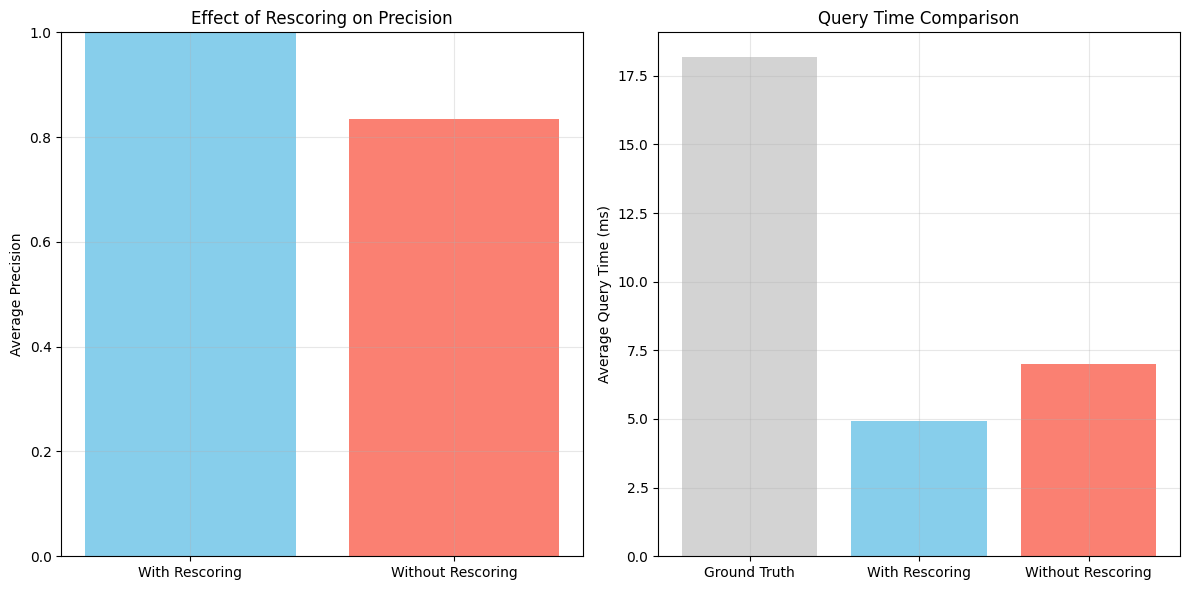

In [7]:
# Visualize the results
plt.figure(figsize=(12, 6))

# Create a bar chart for precision
plt.subplot(1, 2, 1)
plt.bar(['With Rescoring', 'Without Rescoring'], 
        [results[0]['avg_precision'], results[1]['avg_precision']], 
        color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title('Effect of Rescoring on Precision')
plt.ylabel('Average Precision')
plt.grid(True, alpha=0.3)

# Create a bar chart for query time
plt.subplot(1, 2, 2)
plt.bar(['Ground Truth', 'With Rescoring', 'Without Rescoring'], 
        [results[0]['avg_ground_truth_time_ms'], 
         results[0]['avg_quantized_time_ms'], 
         results[1]['avg_quantized_time_ms']], 
        color=['lightgray', 'skyblue', 'salmon'])
plt.title('Query Time Comparison')
plt.ylabel('Average Query Time (ms)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Results Analysis

Run the function two times: first, with rescore = True, and then, with rescore = False. Observe the results and choose the option that reflects the obtained values.

### Select one option from the list

1. With rescoring, the accuracy significantly drops (by more than 0.1), the lack of rescoring makes the accuracy equal to 1, and the queries are much faster than without quantization

2. Without rescoring, the accuracy significantly drops (by more than 0.1), rescoring makes the accuracy equal to 1, and the queries are much faster than without quantization ✅ Correct

3. Rescoring barely affects the accuracy, but with rescore = True, the query speed is significantly lower than with rescore = False
